In [6]:
# Imports
from vespa.package import (
    ApplicationPackage,
    Field,
    Schema,
    Document,
    HNSW,
    RankProfile,
    Component,
    Parameter,
    FieldSet,
    GlobalPhaseRanking,
    Function,
)

from tqdm import tqdm

In [7]:
# Replace with your tenant name from the Vespa Cloud Console
tenant_name = "rcorreaa"
# Replace with your application name (does not need to exist yet)
application = "hybridsearch"

In [8]:
package = ApplicationPackage(
    name=application,
    schema=[
        Schema(
            name="doc",
            document=Document(
                fields=[
                    Field(name="id", type="string", indexing=["summary"]),
                    Field(
                        name="text",
                        type="string",
                        indexing=["index", "summary"],
                        index="enable-bm25",
                    ),
                    Field(
                        name="embedding",
                        type="tensor<float>(x[384])",
                        indexing=[
                            'input text',
                            "embed",
                            "index",
                            "attribute",
                        ],
                        ann=HNSW(distance_metric="angular"),
                        is_document_field=False,
                    ),
                ]
            ),
            fieldsets=[FieldSet(name="default", fields=["text"])],
            rank_profiles=[
                RankProfile(
                    name="bm25",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[
                        Function(name="bm25text", expression="bm25(text)")
                    ],
                    first_phase="bm25text",
                    match_features=["bm25text"],
                ),
                RankProfile(
                    name="dot_product",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        )
                    ],
                    first_phase="cos_sim",
                    match_features=["cos_sim"],
                ),
                RankProfile(
                    name="fusion",
                    inherits="bm25",
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        )
                    ],
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    first_phase="cos_sim",
                    global_phase=GlobalPhaseRanking(
                        expression="reciprocal_rank_fusion(bm25text, closeness(field, embedding))",
                        rerank_count=1000,
                    ),
                    match_features=["cos_sim", "bm25text"],
                ),
            ],
        )
    ],
    components=[
        Component(
            id="e5",
            type="hugging-face-embedder",
            parameters=[
                Parameter(
                    "transformer-model",
                    {
                        "url": "https://github.com/vespa-engine/sample-apps/raw/master/examples/model-exporting/model/e5-small-v2-int8.onnx"
                    },
                ),
                Parameter(
                    "tokenizer-model",
                    {
                        "url": "https://raw.githubusercontent.com/vespa-engine/sample-apps/master/examples/model-exporting/model/tokenizer.json"
                    },
                ),
            ],
        )
    ],
)

In [9]:
from vespa.deployment import VespaCloud
import os

# Key is only used for CI/CD. Can be removed if logging in interactively
key = os.getenv("VESPA_TEAM_API_KEY", None)
if key is not None:
    key = key.replace(r"\n", "\n")  # To parse key correctly

vespa_cloud = VespaCloud(
    tenant=tenant_name,
    application=application,
    application_package=package,
)

Setting application...
Running: vespa config set application rcorreaa.hybridsearch.default
Setting target cloud...
Running: vespa config set target cloud

No api-key found for control plane access. Using access token.
Checking for access token in auth.json...
Successfully obtained access token for control plane access.


In [10]:
app = vespa_cloud.deploy()

Deployment started in run 9 of dev-aws-us-east-1c for rcorreaa.hybridsearch. This may take a few minutes the first time.
INFO    [22:08:08]  Deploying platform version 8.533.16 and application dev build 6 for dev-aws-us-east-1c of default ...
INFO    [22:08:08]  Using CA signed certificate version 1
INFO    [22:08:09]  Using 1 nodes in container cluster 'hybridsearch_container'
INFO    [22:08:10]  Validating Onnx models memory usage for container cluster 'hybridsearch_container', percentage of available memory too low (10 < 15) to avoid restart, consider a flavor with more memory to avoid this
INFO    [22:08:10]  Using 1 nodes in container cluster 'hybridsearch_container'
INFO    [22:08:12]  Validating Onnx models memory usage for container cluster 'hybridsearch_container', percentage of available memory too low (10 < 15) to avoid restart, consider a flavor with more memory to avoid this
INFO    [22:08:13]  Session 243 for tenant 'rcorreaa' prepared and activated.
INFO    [22:08:13]  #

In [11]:
endpoint = vespa_cloud.get_mtls_endpoint()
endpoint

Found mtls endpoint for hybridsearch_container
URL: https://ee226620.fb5b5597.z.vespa-app.cloud/


'https://ee226620.fb5b5597.z.vespa-app.cloud/'

In [12]:
import random
import pickle

PATH = 'subset_msmarco_train_0.01_9.pkl'
PATH_DATA = '../subset_msmarco_train_0/' + PATH

with open(PATH_DATA, "rb") as f:
    data = pickle.load(f)

queries = data["queries"]
query_ids = list(queries.keys())

random.shuffle(query_ids)

train_query_ids = query_ids[:int(len(query_ids) * 0.8)]
test_query_ids = query_ids[int(len(query_ids) * 0.8):]

train_queries = {qid: queries[qid] for qid in train_query_ids}
test_queries = {qid: queries[qid] for qid in test_query_ids}

qrels = data["qrels"]
docs = data["docs"]
vespa_feed = [{"id": doc_id, "fields": {"text": doc_obj.text, "id": doc_id}} for doc_id, doc_obj in docs.items()]

In [13]:
from vespa.io import VespaResponse, VespaQueryResponse


def callback(response: VespaResponse, id: str):
    print(f"Document {id}: {response.get_status_code()}")
    if not response.is_successful():
        print(f"Error when feeding document {id}: {response.get_json()}")


app.feed_iterable(vespa_feed, schema="doc", namespace="tutorial", callback=callback)

Document msmarco_passage_31_315887924: 200
Document msmarco_passage_04_7051408: 200
Document msmarco_passage_31_240307988: 200
Document msmarco_passage_31_602144878: 200
Document msmarco_passage_31_15605486: 200
Document msmarco_passage_04_14046065: 200
Document msmarco_passage_04_6923031: 200
Document msmarco_passage_31_211784428: 200
Document msmarco_passage_04_60569151: 200
Document msmarco_passage_04_41020143: 200
Document msmarco_passage_04_75523089: 200
Document msmarco_passage_04_82541720: 200
Document msmarco_passage_04_64297432: 200
Document msmarco_passage_04_86658804: 200
Document msmarco_passage_04_85507323: 200
Document msmarco_passage_04_87318940: 200
Document msmarco_passage_04_89901538: 200
Document msmarco_passage_04_95687775: 200
Document msmarco_passage_04_98433340: 200
Document msmarco_passage_04_98778978: 200
Document msmarco_passage_04_93748632: 200
Document msmarco_passage_04_102377876: 200
Document msmarco_passage_04_109304595: 200
Document msmarco_passage_04_11

In [14]:
import pandas as pd

def display_hits_as_df(response: VespaQueryResponse, fields) -> pd.DataFrame:
    records = []
    for hit in response.hits:
        record = {}
        for field in fields:
            record[field] = hit["fields"][field]
        records.append(record)
    return pd.DataFrame(records)

In [15]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where userQuery() limit 5",
        query=query,
        ranking="bm25",
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_03_503441468   
1  msmarco_passage_00_465189549   
2  msmarco_passage_04_521200350   
3  msmarco_passage_00_769101016   
4  msmarco_passage_01_512229249   

                                                text  
0  Shopping for Raw Foods. Fruits and vegetables ...  
1  Substitute processed carbohydrates with large ...  
2  How to Broil All Types of Foods for Fast, Flav...  
3  Fruits and Vegetables. Any anti-inflammatory d...  
4  On these pages, you will learn the properties ...  


In [16]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where ({targetHits:5}nearestNeighbor(embedding,q)) limit 5",
        query=query,
        ranking="dot_product",
        body={"input.query(q)": f"embed({query})"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0   msmarco_passage_03_16361113   
1  msmarco_passage_00_443376813   
2  msmarco_passage_00_244409117   
3  msmarco_passage_00_819491144   
4  msmarco_passage_01_644695339   

                                                text  
0  Consume citrus fruits such as lemons, oranges ...  
1  Studies have shown better lung function for pe...  
2  Rather, they are used on a daily basis to help...  
3  Try: Deep Blue, Frankincense, Lavender. \nUsag...  
4  It enhances liver functioning and prevents the...  


In [17]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where userQuery() or ({targetHits:1000}nearestNeighbor(embedding,q)) limit 5",
        query=query,
        ranking="fusion",
        body={"input.query(q)": f"embed({query})"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_00_769101016   
1  msmarco_passage_00_835144191   
2  msmarco_passage_00_271851225   
3  msmarco_passage_00_244409117   
4  msmarco_passage_00_830613246   

                                                text  
0  Fruits and Vegetables. Any anti-inflammatory d...  
1  Unlike meat, fruit and vegetables are equipped...  
2  Vitamin K benefits: Vitamin K is a co-factor i...  
3  Rather, they are used on a daily basis to help...  
4  High-antioxidant foods (especially fruits and ...  


In [18]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where rank({targetHits:1000}nearestNeighbor(embedding,q), userQuery()) limit 5",
        query=query,
        ranking="fusion",
        body={"input.query(q)": f"embed({query})"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_00_769101016   
1  msmarco_passage_00_835144191   
2  msmarco_passage_00_271851225   
3  msmarco_passage_00_244409117   
4  msmarco_passage_00_830613246   

                                                text  
0  Fruits and Vegetables. Any anti-inflammatory d...  
1  Unlike meat, fruit and vegetables are equipped...  
2  Vitamin K benefits: Vitamin K is a co-factor i...  
3  Rather, they are used on a daily basis to help...  
4  High-antioxidant foods (especially fruits and ...  


In [19]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql='select * from sources * where text contains "vegetable" and rank({targetHits:1000}nearestNeighbor(embedding,q), userQuery()) limit 5',
        query=query,
        ranking="fusion",
        body={"input.query(q)": f"embed({query})"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_00_769101016   
1  msmarco_passage_00_835144191   
2  msmarco_passage_03_134550830   
3  msmarco_passage_04_610234918   
4  msmarco_passage_00_830613246   

                                                text  
0  Fruits and Vegetables. Any anti-inflammatory d...  
1  Unlike meat, fruit and vegetables are equipped...  
2  Fruits + Vegetables. Fruits and vegetables can...  
3  For example, citrus fruits like lemon, berries...  
4  High-antioxidant foods (especially fruits and ...  


In [20]:
from vespa.evaluation import VespaEvaluator

?VespaEvaluator

Init signature:
VespaEvaluator(
    queries: 'Dict[str, str]',
    relevant_docs: 'Union[Dict[str, Union[Set[str], Dict[str, float]]], Dict[str, str]]',
    vespa_query_fn: 'Callable[[str, int, Optional[str]], dict]',
    app: 'Vespa',
    name: 'str' = '',
    id_field: 'str' = '',
    accuracy_at_k: 'List[int]' = [1, 3, 5, 10],
    precision_recall_at_k: 'List[int]' = [1, 3, 5, 10],
    mrr_at_k: 'List[int]' = [10],
    ndcg_at_k: 'List[int]' = [10],
    map_at_k: 'List[int]' = [100],
    write_csv: 'bool' = False,
    csv_dir: 'Optional[str]' = None,
)
Docstring:     
Evaluate retrieval performance on a Vespa application.

This class:

- Iterates over queries and issues them against your Vespa application.
- Retrieves top-k documents per query (with k = max of your IR metrics).
- Compares the retrieved documents with a set of relevant document ids.
- Computes IR metrics: Accuracy@k, Precision@k, Recall@k, MRR@k, NDCG@k, MAP@k.
- Logs vespa search times for each query.
- Logs/returns

In [21]:
import vespa.querybuilder as qb

def lexical_bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();", 
        "query": query_text,
        "ranking": "bm25",
        "hits": top_k,
    }

def lexical_dot_product_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();",
        "query": query_text,
        "ranking": "dot_product",
        "hits": top_k,
    }

def lexical_fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();",
        "query": query_text,
        "ranking": "fusion",
        "hits": top_k,
    }

def semantic_bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "bm25",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
    }

def semantic_dot_product_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "dot_product",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
    }

def semantic_fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "fusion",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
    }

def hybrid_bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "bm25",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
    }

def hybrid_dot_product_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "dot_product",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
    }

def hybrid_fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "fusion",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
    }

In [22]:
from vespa.io import VespaQueryResponse

response: VespaQueryResponse = app.query(
    body=semantic_bm25_query_fn("how to bake a cake", 3)
)

In [23]:
response.get_json()

{'root': {'id': 'toplevel',
  'relevance': 1.0,
  'fields': {'totalCount': 1000},
  'coverage': {'coverage': 100,
   'documents': 277153,
   'full': True,
   'nodes': 1,
   'results': 1,
   'resultsFull': 1},
  'children': [{'id': 'id:tutorial:doc::msmarco_passage_04_98433340',
    'relevance': 0.0,
    'source': 'hybridsearch_content',
    'fields': {'matchfeatures': {'bm25text': 0.0},
     'sddocname': 'doc',
     'documentid': 'id:tutorial:doc::msmarco_passage_04_98433340',
     'id': 'msmarco_passage_04_98433340',
     'text': "How long do you cook a 3 lb meatloaf? - Answers. You should bake meatloaf at 350 degrees F for 30-40- minutes per\npound if cooked in a bread pan. If cooked in a shallow pan, it\nwon't take as long for the center to get done."}},
   {'id': 'id:tutorial:doc::msmarco_passage_63_688083500',
    'relevance': 0.0,
    'source': 'hybridsearch_content',
    'fields': {'matchfeatures': {'bm25text': 0.0},
     'sddocname': 'doc',
     'documentid': 'id:tutorial:doc::

In [24]:
ids_to_queries = {query.query_id: query.text for query in train_queries.values()}

for i in range(5):
    query_id = list(ids_to_queries.keys())[i]
    print(f"Query ID: {query_id}, Query Text: {ids_to_queries[query_id]}")

Query ID: 1079447, Query Text: words to describe abe lincoln life
Query ID: 991315, Query Text: where is rait castle
Query ID: 879621, Query Text: what municipality is whiting, nj
Query ID: 180544, Query Text: engine replacement when oil leaks
Query ID: 526269, Query Text: types of allergic rashes


In [25]:
relevant_docs = {}
for qrel in qrels:
    query_id = qrel.query_id
    doc_id = qrel.doc_id
    if query_id not in relevant_docs:
        relevant_docs[query_id] = set()
    relevant_docs[query_id].add(doc_id)

for i in range(5):
    query_id = list(relevant_docs.keys())[i]
    print(f"Query ID: {query_id}, Relevant Docs: {relevant_docs[query_id]}")

Query ID: 135841, Relevant Docs: {'msmarco_passage_16_93510573'}
Query ID: 1072113, Relevant Docs: {'msmarco_passage_03_76282697'}
Query ID: 66325, Relevant Docs: {'msmarco_passage_03_779837601'}
Query ID: 622007, Relevant Docs: {'msmarco_passage_18_4266000'}
Query ID: 406188, Relevant Docs: {'msmarco_passage_58_532087922'}


In [ ]:
# from collections import defaultdict

# ids_to_queries = {qid: q.text for qid, q in data["queries"].items()}

# relevant_docs = defaultdict(set)

# for qid, _, docid, score in data["qrels"]:
#     if int(score) > 0:
#         relevant_docs[qid].add(docid)
        
# relevant_docs = dict(relevant_docs)

In [26]:
all_results = {}
for evaluator_name, query_fn in [
    ("lexical_b25", lexical_bm25_query_fn),
    ("lexical_dot_product", lexical_dot_product_query_fn),
    ("lexical_fusion", lexical_fusion_query_fn),
    ("semantic_bm25", semantic_bm25_query_fn),
    ("semantic_dot_product", semantic_dot_product_query_fn),
    ("semantic_fusion", semantic_fusion_query_fn),
    ("hybrid_bm25", hybrid_bm25_query_fn),
    ("hybrid_dot_product", hybrid_dot_product_query_fn),
    ("hybrid_fusion", hybrid_fusion_query_fn),
]:
    print(f"Evaluating {evaluator_name}...")
    evaluator = VespaEvaluator(
        queries=ids_to_queries,  
        relevant_docs=relevant_docs,
        vespa_query_fn=query_fn,
        app=app,
        name=evaluator_name,
        write_csv=True,  # optionally write metrics to CSV
    )

    results = evaluator.run()
    all_results[evaluator_name] = results

Evaluating lexical_b25...


KeyboardInterrupt: 

In [ ]:
import pandas as pd

results = pd.DataFrame(all_results)

In [ ]:
# take out all rows with "searchtime" to a separate dataframe
searchtime = results[results.index.str.contains("searchtime")]
results = results[~results.index.str.contains("searchtime")]


# Highlight the maximum value in each row
def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: lightgreen; color: black;" if v else "" for v in is_max]


# Style the DataFrame: Highlight max values and format numbers to 4 decimals
styled_df = results.style.apply(highlight_max, axis=1).format("{:.4f}")
styled_df

,lexical_b25,lexical_dot_product,lexical_fusion,semantic_bm25,semantic_dot_product,semantic_fusion,hybrid_bm25,hybrid_dot_product,hybrid_fusion
accuracy@1,0.4116,0.0036,0.2951,0.1218,0.6309,0.6309,0.4116,0.6372,0.5659
accuracy@3,0.5627,0.0077,0.4657,0.3227,0.7789,0.7789,0.5627,0.7884,0.7288
accuracy@5,0.6273,0.0135,0.5325,0.4883,0.8208,0.8208,0.6273,0.8312,0.7893
accuracy@10,0.7044,0.0302,0.6142,0.7748,0.8633,0.8633,0.7044,0.8736,0.8488
precision@1,0.4116,0.0036,0.2951,0.1218,0.6309,0.6309,0.4116,0.6372,0.5659
recall@1,0.4048,0.0036,0.2893,0.1209,0.6221,0.6221,0.4048,0.6284,0.5571
precision@3,0.1894,0.0026,0.1573,0.1083,0.2628,0.2628,0.1894,0.2659,0.2461
recall@3,0.5566,0.0072,0.4605,0.3170,0.7717,0.7717,0.5566,0.7811,0.7222
precision@5,0.1268,0.0028,0.1084,0.0989,0.1671,0.1671,0.1268,0.1691,0.1605
recall@5,0.6207,0.0133,0.5280,0.4819,0.8157,0.8157,0.6207,0.8260,0.7836


<Axes: >

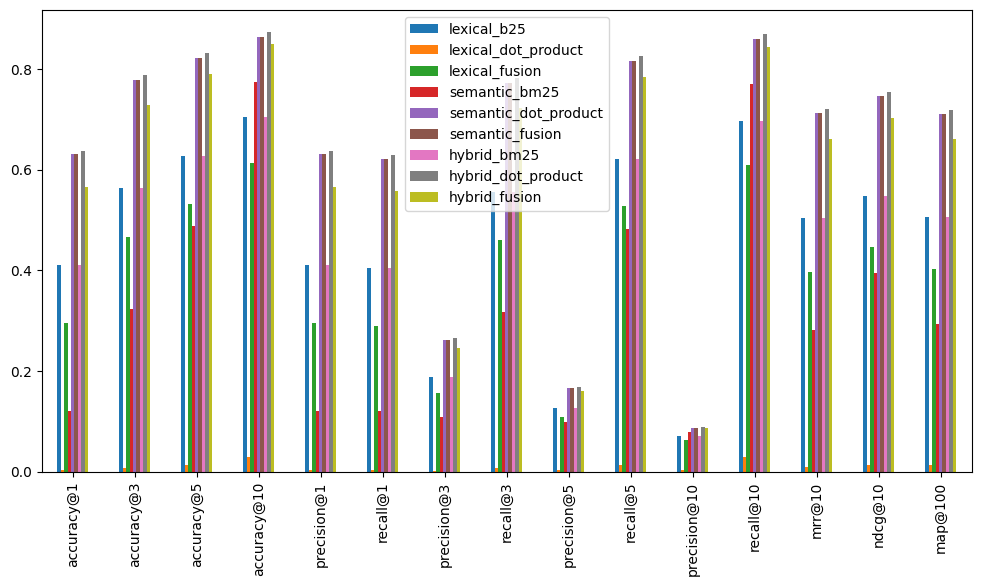

In [ ]:
results.plot(kind="bar", figsize=(12, 6))

[Text(0, 0.5, 'time (ms)')]

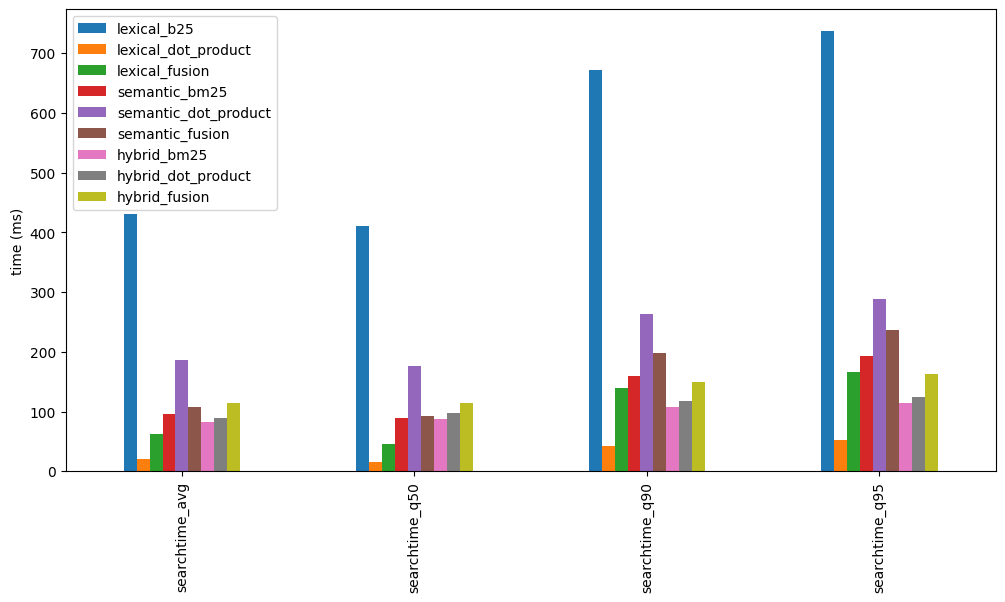

In [ ]:
# plot search time, add (ms) to the y-axis
# convert to ms
searchtime = searchtime * 1000
searchtime.plot(kind="bar", figsize=(12, 6)).set(ylabel="time (ms)")

In [27]:
def calculate_mrr_at_10(results: dict, relevant_docs: dict) -> float:
    """
    Calcula o MRR@10 para um conjunto de queries.

    Parâmetros:
        - results: dict {query_id: list of predicted doc_ids em ordem ranqueada}
        - relevant_docs: dict {query_id: set of ground-truth relevant doc_ids}

    Retorna:
        - MRR@10 (float)
    """
    reciprocal_ranks = []
    for query_id, predicted_doc_ids in results.items():
        found = False
        for rank, doc_id in enumerate(predicted_doc_ids[:10], start=1):
            if doc_id in relevant_docs.get(query_id, set()):
                reciprocal_ranks.append(1.0 / rank)
                found = True
                break
        if not found:
            reciprocal_ranks.append(0.0)
    return sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0.0


In [28]:
from sentence_transformers import CrossEncoder

def rerank_cross_encoder(query_text, docs, top_k=10):
    """
    Rerank documentos com base em um Cross-Encoder.
    
    Parâmetros:
        query_text: str, o texto da query
        docs: list of tuples (text, doc_id)
        top_k: int, número de documentos reranqueados a retornar

    Retorna:
        Lista de tuplas (doc_text, doc_id, score) ordenada por score decrescente
    """
    # Inicializa o modelo (você pode mover isso para fora da função depois se quiser)
    model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

    # Monta os pares (query, doc_text)
    pairs = [(query_text, doc_text) for (doc_text, _) in docs]

    # Reranqueia
    scores = model.predict(pairs)

    # Associa cada score ao seu texto e ID original
    scored_docs = [(doc_text, doc_id, score) for ((doc_text, doc_id), score) in zip(docs, scores)]

    # Ordena por score decrescente
    reranked = sorted(scored_docs, key=lambda x: x[2], reverse=True)

    return reranked[:top_k]


c:\Users\ramyr\miniconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [29]:
# Escolhe um qid válido (exemplo: o primeiro da lista)
qid = list(queries.keys())[0]

# Extrai o texto da query
query_text = queries[qid].text

# Extrai os documentos do response (certifique-se de ter executado uma busca antes!)
docs = [(hit["fields"]["text"], hit["id"]) for hit in response.hits]

# Reranqueia com Cross-Encoder (assumindo que a função rerank_cross_encoder já está definida)
reranked_docs = rerank_cross_encoder(query_text, docs, top_k=10)

# Mostra os resultados reranqueados
for text, doc_id, score in reranked_docs:
    print(f"{doc_id} → {score:.4f}")


id:tutorial:doc::msmarco_passage_63_688083500 → -10.9786
id:tutorial:doc::msmarco_passage_10_517985636 → -11.1884
id:tutorial:doc::msmarco_passage_04_98433340 → -11.2454


In [30]:
results = {}

for qid in tqdm(list(relevant_docs.keys())[:50], desc="Reranking"):
    query_text = queries[qid].text

    # Recupera documentos do Vespa com top_k inicial (por exemplo, 100)
    response = app.query(body=hybrid_dot_product_query_fn(query_text, top_k=100))
    docs = [(hit["fields"]["text"], hit["id"].replace("id:tutorial:doc::", "")) for hit in response.hits]

    # Reranqueia com Cross-Encoder
    reranked_docs = rerank_cross_encoder(query_text, docs, top_k=10)

    # Armazena apenas os doc_ids reranqueados
    results[qid] = [doc_id for _, doc_id, _ in reranked_docs]

# Calcula MRR@10
mrr = calculate_mrr_at_10(results, relevant_docs)
print(f"MRR@10: {mrr:.4f}")


Reranking:   0%|          | 0/50 [00:00<?, ?it/s]

Reranking: 100%|██████████| 50/50 [03:59<00:00,  4.78s/it]

MRR@10: 0.7273


In [31]:
def vespa_random_search(queries, K=10, seed=42):
    results = {}
    for qid, q in queries.items():
        resp = vespa_cloud.query(
            body = {
                "yql": "select * from sources * where userQuery();",
                "query": q,
                "hits": K,
                "ranking": "random",         # << rank-profile random { first-phase { expression: rand(seed) } }
                "ranking.features.query(seed)": seed
            }
        )
        results[qid] = [hit["id"].split("::")[-1] for hit in resp.hits]
    return results

In [32]:
def vespa_bm25_search(queries, K=10):
    results = {}
    for qid, q in queries.items():
        resp = vespa_cloud.query(
            body={
                "yql": "select * from sources * where userQuery();",
                "query": q,
                "hits": K,
                "ranking": "bm25"
            }
        )
        results[qid] = [hit["id"].split("::")[-1] for hit in resp.hits]
    return results

In [33]:
from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer("colbert-ir/colbertv2.0")

def vespa_colbert_search(queries, K=10):
    results = {}
    for qid, q in queries.items():
        q_vec = encoder.encode(q).tolist()   # 768-dim list
        resp = VESPA_APP.query(
            body={
                "yql": "select * from sources * where "
                       "({targetHits:%d}nearestNeighbor(colbert_vec, q_vec));" % K,
                "hits": K,
                "ranking": "closeness",
                "input.query(q_vec)": q_vec
            }
        )
        results[qid] = [hit["id"].split("::")[-1] for hit in resp.hits]
    return results

No sentence-transformers model found with name colbert-ir/colbertv2.0. Creating a new one with mean pooling.
c:\Users\ramyr\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ramyr\.cache\huggingface\hub\models--colbert-ir--colbertv2.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
vespa_cloud.delete()